In [447]:
import matplotlib.pyplot as plt
import bettermoments as bm
import numpy as np

from multiprocessing import Pool
import matplotlib.pyplot as plt
from eddy import rotationmap
from matplotlib.backends.backend_pdf import PdfPages
import corner
import pandas as pd
import inspect
from tqdm import tqdm

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import Angle
from mpl_point_clicker import clicker
from disk_dictionary2 import disk_dict
from disk_dictionary2 import get_dict
import os
from ipywidgets import interact

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from io import BytesIO
import pdfkit 
from pypdf import PdfMerger
import skimage 
from fpdf import FPDF
from astropy.wcs import WCS
from matplotlib.patches import Ellipse
#https://bulk.cv.nrao.edu/deco/users/cjlaw/IMAGING/
%matplotlib inline

In [144]:
inspect.getargspec(cube.fit_map)

ArgSpec(args=['self', 'p0', 'params', 'r_min', 'r_max', 'optimize', 'nwalkers', 'nburnin', 'nsteps', 'scatter', 'plots', 'returns', 'pool', 'mcmc', 'mcmc_kwargs', 'niter'], varargs=None, keywords=None, defaults=(None, None, True, None, 300, 100, 0.001, None, None, None, 'emcee', None, 1))

In [508]:
def process_data(infile, m_values, sigma_clip):

    data, velax = bm.load_cube(infile)
    rms = bm.estimate_RMS(data=data, N=5)

    postage_stamp_fig = create_postage_stamps(data, infile)


    # define mask based on carta
    m = np.zeros(data.shape[0])
    if m_values[0] == 'full':
        m1,m2,m3,m4 = 0, len(m), 0, len(m)
    else:
        m1,m2,m3,m4 = m_values
    
    m[m1:m2] = 1
    m[m3:m4] = 1

    channel_mask = bm.get_channel_mask(data=data, user_mask=m)
    threshold_mask = bm.get_threshold_mask(data=data, clip=sigma_clip)

    data_masked = data * channel_mask * threshold_mask

    # if pos_mask == None:
    #     data_masked = data * channel_mask * threshold_mask
    # else:
    #     data_masked = data * channel_mask * threshold_mask*pos_mask


    #v0, dv0, Fnu, dFnu = bm.collapse_quadratic(velax, data, rms)
    moments = bm.collapse_quadratic(velax, data_masked, rms)
    v0, dv0, Fnu, dFnu = moments


    bad_indices =  v0<=np.median(v0) 

    v0[bad_indices] = np.nan
    dv0[bad_indices] = np.nan
    Fnu[bad_indices] = np.nan
    dFnu[bad_indices] = np.nan

    min_v0, max_v0 = np.min(v0), np.max(v0)

    bm.save_to_FITS(moments =(v0, dv0, Fnu, dFnu), method='quadratic', path=infile)


    return min_v0, max_v0, v0, postage_stamp_fig, data.shape

def create_postage_stamps(data, infile):
    name = infile.split('/')[-1].split('_')[0]
    emission_line = infile.split('/')[-1].split('_')[1]

    data_size = int(np.round(len(data[0])/2))
    fov = 100
    nrows = 4
    ncols = 5
    f, axes = plt.subplots(nrows, ncols, figsize= (15,15))
    channel_vals = np.arange(10,210,10)

    for nrow in tqdm(range(nrows)):
        for ncol in range(ncols):
            ax = axes[nrow][ncol]
            channel = channel_vals[5*nrow+ncol]
            im = ax.imshow(data[channel][data_size-fov:data_size+fov, data_size-fov:data_size+fov])
            ax.set_title(f'Channel: {channel}')
        
    plt.suptitle(f'{name}, {emission_line}')
    plt.show()

    return f

def create_velocity_map(infile, m_values, beam, v0, contours, clevels, mask): 

    m1, m2,m3,m4 = m_values

    name = infile.split('/')[-1].split('_')[0]
    region = infile.split('/')[-2]

    hdul = fits.open(infile)  # open as FITS file
    hdr = hdul[0].header  # the primary HDU header
    dec = hdr['CRVAL2'] 
    ra = hdr['CRVAL1'] 


    center_ra = disk_dict[region][name]['RA']
    center_dec = disk_dict[region][name]['Dec']

    print(center_ra, center_dec)
    print(Angle(center_ra * u.degree).hms,Angle(center_dec * u.degree).dms)
    # center_ra, center_dec = 164.75512575819914, -77.37824095879179
    

    ra_diff_arcsecond = (center_ra - ra) * np.cos(dec*np.pi/180)*3600
    dec_diff_arcsecond = (center_dec - dec) * 3600


    ## do Eddy stuff
    name = infile.split('/')[-1].split('_')[0]
    cube = rotationmap(path=f'{infile[:-5]}_v0.fits',
                    uncertainty=f'{infile[:-5]}_dv0.fits',
                    FOV=beam)

    v_scaling = np.nanmin(v0[575:675, 575:675])/1000, np.nanmax(v0[575:675, 575:675])/1000
    rot_fig = cube.plot_data(vmin=v_scaling[0], vmax=v_scaling[1], return_fig=True)
    rot_axes_list = rot_fig.axes
    rot_axes_list[0].set_title('Channels: '+f'{m1}-{m2},{m3}-{m4}')
    rot_axes_list[0].scatter(ra_diff_arcsecond, dec_diff_arcsecond, color='black',s=20)


    for wcscont_num in range(len(contours)): 
        wcscont = contours[wcscont_num]
        if wcscont_num == 0:
            rot_axes_list[0].plot((wcscont[1]-ra)*3600*np.cos(dec*np.pi/180),(wcscont[0]-dec)*3600,color='black',label=f'Continuum Contour at {clevels}',ls='--')
        else:
            rot_axes_list[0].plot((wcscont[1]-ra)*3600*np.cos(dec*np.pi/180),(wcscont[0]-dec)*3600,color='black',ls='--')

    rot_fig.suptitle(name)

    if mask != None:
        ellipse = Ellipse((mask[2],mask[3]), width=2*mask[0], height=2*mask[1], angle=mask[4], edgecolor='black', ls='dotted',facecolor='none',label='mask')
        # Add ellipse to plot
        plt.gca().add_patch(ellipse)



    plt.legend()

    return cube, rot_fig, (ra_diff_arcsecond,dec_diff_arcsecond), v_scaling


def mask_cube(ellipse_mask, infile, beam, v_scaling):

    for vfile in [f'{infile[:-5]}_v0.fits', f'{infile[:-5]}_dv0.fits']:
        hdul = fits.open(vfile)
        image_data = hdul[0].data  # Assuming the image data is in the primary HDU
        image_data = np.flipud(image_data)

        masked_image_data = image_data * ellipse_mask
        bad_indices =  masked_image_data == 0
        masked_image_data[bad_indices] = np.nan

        masked_image_data = np.flipud(masked_image_data)
        
        hdul[0].data = masked_image_data
        hdul.writeto(f'{vfile[:-5]}_masked.fits', overwrite=True)
        hdul.close()

    masked_cube = rotationmap(path=f'{infile[:-5]}_v0_masked.fits',
                uncertainty=f'{infile[:-5]}_dv0_masked.fits',
                FOV=beam)
    

    masked_cube.plot_data(vmin=v_scaling[0], vmax=v_scaling[1])

    plt.title("masked data")
    plt.show()
    return masked_cube


def run_eddy_mcmc(cube, offsets, annulus, PA_guess, nwalkers, nburn, nsims):

    name = infile.split('/')[-1].split('_')[0]
    region = infile.split('/')[-2]
    # Dictionary to contain the disk parameters.
    mass_prior =  disk_dict[region][name]['M_star']
    distance =   disk_dict[region][name]['distance']
    lit_inc =   disk_dict[region][name]['inclination']

    print(f'SET -- x_offset: {offsets[0]}, y_offset: {offsets[1]}, mass: {mass_prior}, distance: {distance}, inc: {lit_inc}')


    params = {}



    # Start with the free variables in p0.
    params['PA'] = 0

    if lit_inc != '--' and lit_inc != 0:
        print('fixing inclination')
        params['vlsr'] = 1
        params['mstar'] = 2
        params['inc'] = float(lit_inc) # degrees
        p0 = [PA_guess,4e3, mass_prior, ]
    else:
        print('fixing mass')
        params['vlsr'] = 1
        params['inc'] = 2
        params['mstar'] = mass_prior
        p0 = [PA_guess, 4e3, 20]


    params['x0'] = offsets[0]
    params['y0'] = offsets[1]
    params['dist'] = distance   # parsec

    params['r_min'] = float(annulus[0])
    params['r_max'] = float(annulus[1])


    samples, resid_fig = cube.fit_map(p0=p0, params=params,
                        nwalkers=nwalkers, nburnin=nburn, nsteps=nsims)



    return samples, params, resid_fig 

def plot_model_and_resids(samples, params, v_scaling, rot_fig, resid_fig, disk_row, postage_stamp_fig):

    name = infile.split('/')[-1].split('_')[0]
    line = infile.split('/')[-1].split('_')[1]

    PA = np.median([x[0] for x in samples])
    PA_err_plus, PA_err_minus = np.percentile([x[0] for x in samples],84), np.percentile([x[0] for x in samples],16)

    model = cube.evaluate_models(samples=samples, params=params)
    model_fig = cube.plot_model(model=model, return_fig = True, imshow_kwargs = {'vmin': v_scaling[0], 'vmax': v_scaling[1]})

    axes_list = model_fig.axes

    PA_slope = np.tan((PA+90)*np.pi / 180)
    PA_slope_plus = np.tan((PA_err_plus+90)*np.pi / 180)
    PA_slope_minus = np.tan((PA_err_minus+90)*np.pi / 180)


    x= np.arange(-5,5,.1)
    PA_line = -x * PA_slope
    PA_line_plus = -x * PA_slope_plus
    PA_line_min = -x * PA_slope_minus

    ra_diff_arcsecond, dec_diff_arcsecond = params['x0'], params['y0']

    axes_list[0].scatter(ra_diff_arcsecond, dec_diff_arcsecond, color='black',s=20)

    
    axes_list[0].plot(x+ra_diff_arcsecond,PA_line_plus+dec_diff_arcsecond,color='black',ls='-',linewidth=1)
    axes_list[0].plot(x+ra_diff_arcsecond,PA_line_min+dec_diff_arcsecond,color='black',ls='-',linewidth=1)


    model_fig.suptitle(f"{infile.split('/')[-1].split('_')[0]}",fontsize=15)
    axes_list[0].set_title(f"PA: {np.round(PA,1)}$^\degree$"+f" -- Offset ({np.round(ra_diff_arcsecond,2)},{np.round(dec_diff_arcsecond,2)})", fontsize=13,pad=5)
    axes_list[0].scatter(ra_diff_arcsecond,dec_diff_arcsecond,s=50,color='black')
    name = infile.split('/')[-1].split('_')[0]


    # resid_fig = cube.plot_model_residual(model=model, return_fig=True)


    rot_fig.axes[0].plot(x+params['x0'],PA_line_plus+params['y0'],color='black',linewidth=1)
    rot_fig.axes[0].plot(x+params['x0'],PA_line_min+params['y0'],color='black',linewidth=1)




    corner_fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], labels=[l for l in list(params.keys())[0:len(samples[0])]], label_kwargs={"fontsize": 15}, show_titles=True, bins= 60)



    figs = [postage_stamp_fig, rot_fig,model_fig,resid_fig,corner_fig] # list of figures
    pdf_file_path = f'/Users/calebpainter/Downloads/DustDrift2DiskMass/disk_plots_v/full_diagnostic_{name}_{line}_{nsims}_sim_{nwalkers}_walkers.pdf'
    with PdfPages(pdf_file_path) as pdf:
        for fig in figs:
            pdf.savefig(fig, bbox_inches='tight') 

    with open(f'/Users/calebpainter/Downloads/DustDrift2DiskMass/disk_rows/{name}_{line}.txt','w') as f:  
        for key, value in disk_row.items():  
                f.write('%s: %s\n' % (key, value))    
    pdf = FPDF()   
    pdf.add_page()
    pdf.set_font("Arial", size = 8)
    f = open(f'/Users/calebpainter/Downloads/DustDrift2DiskMass/disk_rows/{name}_{line}.txt', 'r')
    for x in f:
        pdf.cell(200, 10, txt = x, ln = 1, align = 'C')
    pdf.output(f'/Users/calebpainter/Downloads/DustDrift2DiskMass/disk_rows/{name}_{line}.pdf')   

    pdfs = [pdf_file_path,f'/Users/calebpainter/Downloads/DustDrift2DiskMass/disk_rows/{name}_{line}.pdf']

    merger = PdfMerger()

    for pdf in pdfs:
        merger.append(pdf)

    merger.write(f'/Users/calebpainter/Downloads/DustDrift2DiskMass/disk_plots_v/full_diagnostic_with_dict_{name}_{line}_{nsims}_sim_{nwalkers}_walkers.pdf')
    merger.close()


    return model_fig, resid_fig, rot_fig


def get_cont_file(infile):
    name = infile.split('/')[-1].split('_')[0]

    file_dir = '/Users/calebpainter/Downloads/products/new'
    file_dirs = os.listdir(file_dir)
    all_cont_files = []
    for fdir in file_dirs:
        try:
            new_dir = file_dir+'/'+fdir+'/cont_images/'
            region_files = os.listdir(new_dir)
            all_cont_files.append([new_dir + x for x in region_files])
        except:
            pass

    disk_cont_file = None

    for sublist in all_cont_files:
        for item in sublist:
            if name in item:
                disk_cont_file = item
    print(disk_cont_file)
    return disk_cont_file

def plot_fits(image_file, fov):
    hdu_list = fits.open(image_file)
    print(hdu_list.info())
    image_data = hdu_list[0].data
    image_data = image_data.squeeze()
    image_data = image_data[(250 - fov):(250+fov), (250 - fov):(250+fov)]
    print(np.nanmax(image_data))
    image_data = image_data / np.nanmax(image_data)
    print(np.nanmax(image_data))
    plt.imshow(image_data)
    plt.colorbar()


    wcs = WCS(hdu_list[0].header)  #

    skcontours = []
    skcontours_wcs = []
    contour_levels = [.05, .20, .50, .90]
    for level in contour_levels: 
        skcontour = skimage.measure.find_contours(image_data,level =level)
        skcontours.append(skcontour)

        for contour in skcontour:
            y, x = contour.T  # Extract contour coordinates
            lat, lon, _, _ = wcs.all_pix2world(x + (250 - fov), y + (250 - fov), 0, 0, 0) # Convert to RA, DEC
            skcontours_wcs.append([lon, lat])

    for skcontour in skcontours:
        try:
            plt.plot([x[1] for x in skcontour[0]],[x[0] for x in skcontour[0]],color='white')
        except:
            print("bad")

    return skcontours_wcs, contour_levels

def create_ellipse_array(a, b, theta, center, infile, data_shape):

    depth = data_shape[0]
    size= data_shape[1]



    hdul = fits.open(f'{infile[:-5]}_v0.fits')  # open as FITS file
    hdr = hdul[0].header  # the primary HDU header
    dec_scale = hdr['CDELT2'] 
    ra_scale = hdr['CDELT1'] 

    a /= (ra_scale*3600)
    b /= (dec_scale*3600)

    center[0] /= (ra_scale*3600*size/2)
    center[1] /= (dec_scale*3600*size/2)

    print(a,b)

    a /= (size/2)
    b /= (size/2)



    print(a,b)
    theta += 90
    
    # Create a grid of size x size
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    
    # Convert angle from degrees to radians
    theta_rad = np.deg2rad(theta)
    
    # Compute the equation of the ellipse
    ellipse_eq = (((X-center[0]) * np.cos(theta_rad) + (Y-center[1]) * np.sin(theta_rad))**2 / b**2 
                  + ((X-center[0]) * np.sin(theta_rad) - (Y-center[1]) * np.cos(theta_rad))**2 / a**2)
    
    # Create mask for points inside the ellipse
    ellipse_mask = ellipse_eq <= 1

    
    return ellipse_mask.astype(int)  # Convert boolean array to integer (0 or 1)


In [312]:
'''LUPUS'''
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/Lupus/Sz68_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/Lupus/Sz90_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/Lupus/Sz96_CO_230.538GHz.image.fits'

'''ROph'''

# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162616.8-242223_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162618.9-242820_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162624.1-241613_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162636.8-241552_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162649.0-243825_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162656.8-241351_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162713.7-241817_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162730.2-242743_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162733.1-244115_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162738.3-243658_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162739.0-235818_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ROph/J162854.1-244744_CO_230.538GHz.image.fits'

'''Cham'''

# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J10555973-7724399_CO_230.538GHz.image.fits' 
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J10590108-7722407_CO_230.538GHz.image.fits'
infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J11075792-7738449_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J11080148-7742288_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J11085367-7521359_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J11095340-7634255_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J11095407-7629253_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J11100369-7633291_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J11100704-7629376_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J11105333-7634319_CO_230.538GHz.image.fits'
# infile = '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J11173700-7704381_CO_230.538GHz.image.fits'



/Users/calebpainter/Downloads/products/new/ChaI_CCH_setting/cont_images/member.uid___A001_X2d20_X1f2b.J11075792-7738449_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits
Filename: /Users/calebpainter/Downloads/products/new/ChaI_CCH_setting/cont_images/member.uid___A001_X2d20_X1f2b.J11075792-7738449_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     420   (500, 500, 1, 1)   float32   


None
0.008762449
1.0


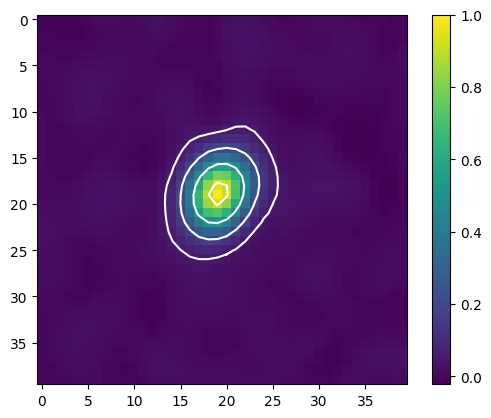

In [324]:
#Grab corresponding Continuum File

disk_cont_file = get_cont_file(infile)
skcontours_wcs, contour_levels = plot_fits(disk_cont_file, 20)

100%|██████████| 4/4 [00:00<00:00,  9.57it/s]


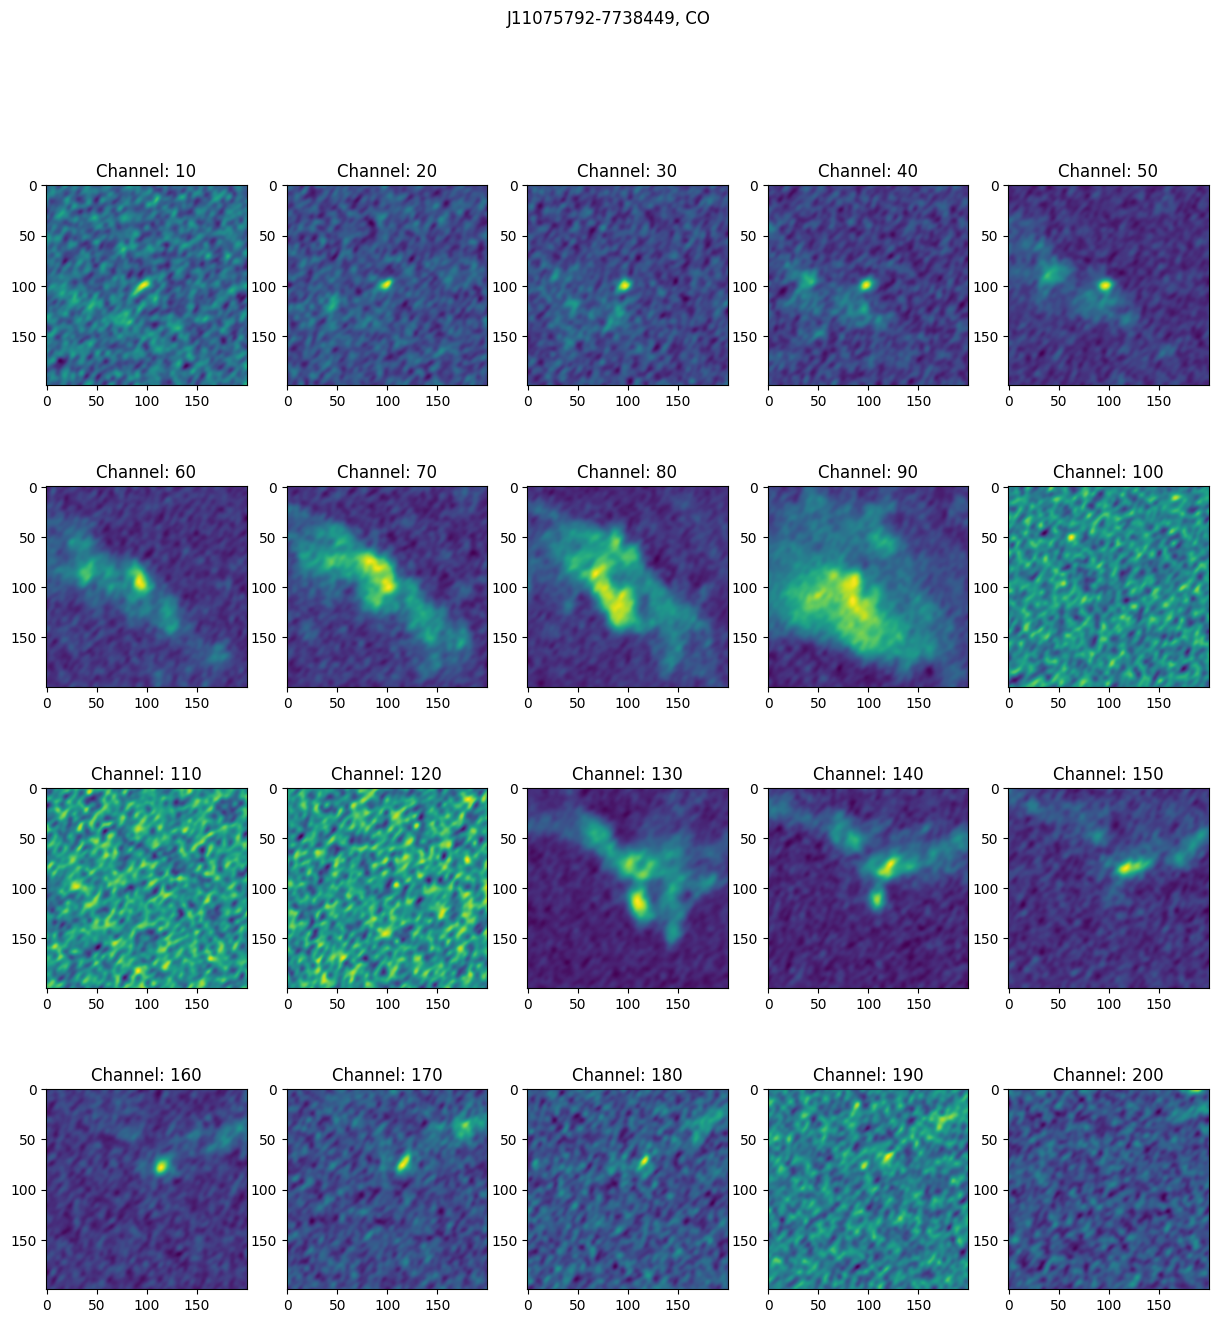

In [469]:
channels = 0, 50, 150, 200
min_v0, max_v0, v0, postage_stamp_fig, data_shape = process_data(infile, channels, 5)

166.9906645833333 -77.64582250000001
hms_tuple(h=11.0, m=7.0, s=57.759499999999804) dms_tuple(d=-77.0, m=-38.0, s=-44.96100000003025)


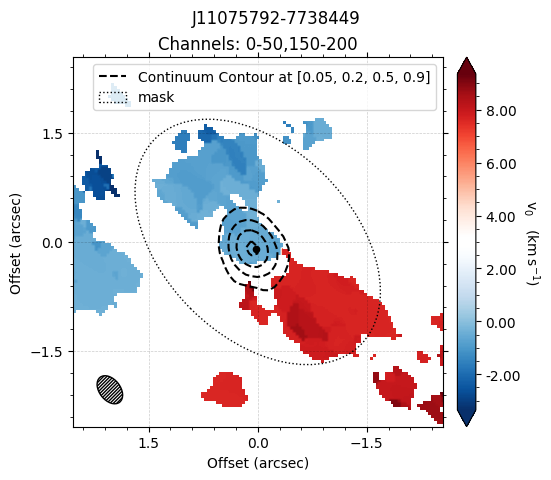

In [504]:
mask = [2, 1.3,0,0,45]
beam = 5
cube, rot_fig, offsets, v_scaling = create_velocity_map(infile, channels, beam, v0, skcontours_wcs, contour_levels, mask)

-50.000000000004995 32.50000000000325
-0.080000000000008 0.052000000000005195


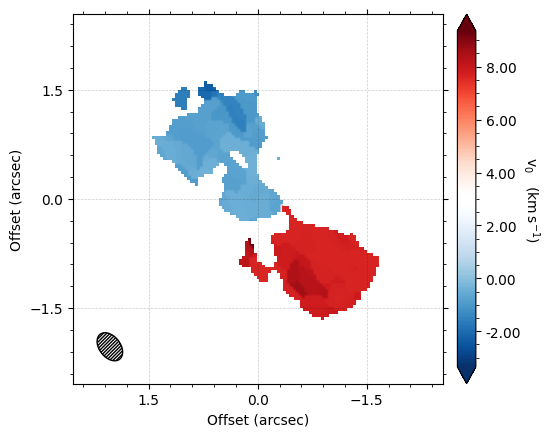

SET -- x_offset: 0.020622417104469222, y_offset: -0.09425664002264966, mass: 0.82, distance: 191.0, inc: --
fixing mass
Changed File
Assuming:
	p0 = [PA, vlsr, inc].
Starting positions:
	p0 = ['2.30e+02', '4.00e+03', '2.00e+01']


100%|██████████| 600/600 [00:59<00:00, 10.06it/s]


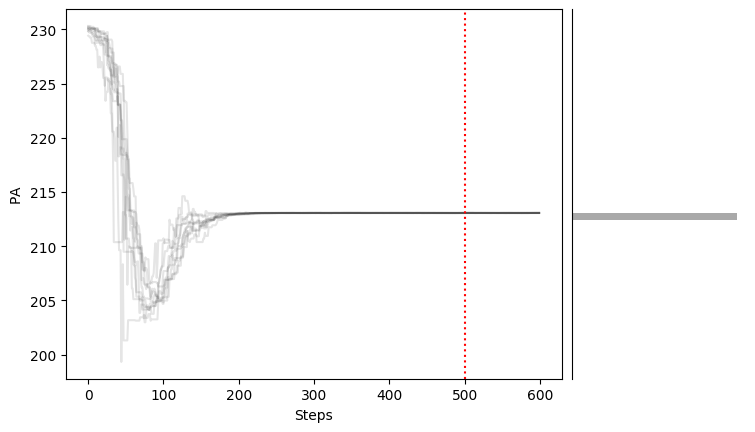

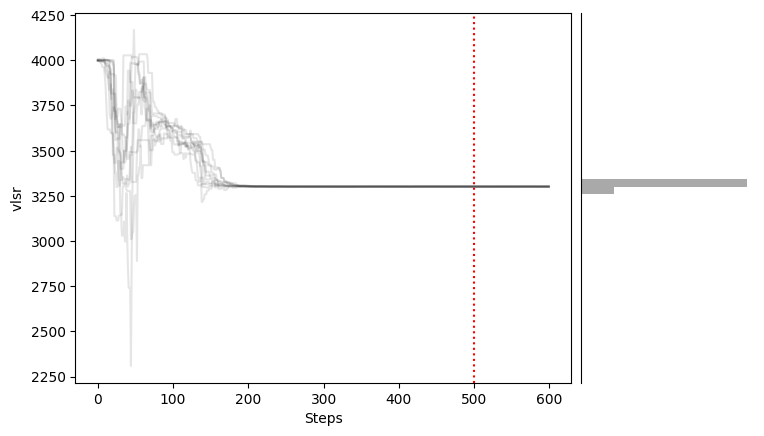

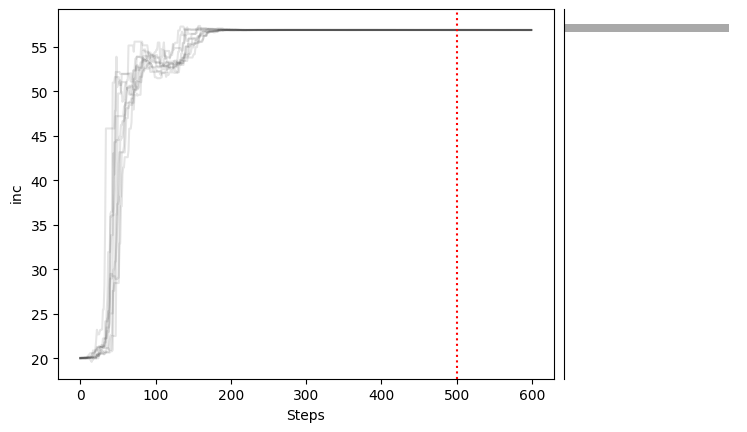

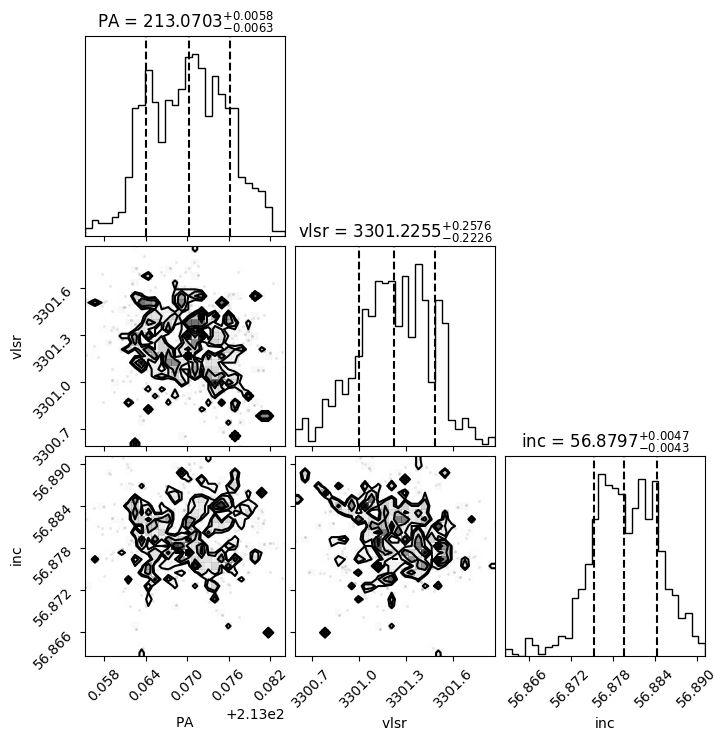

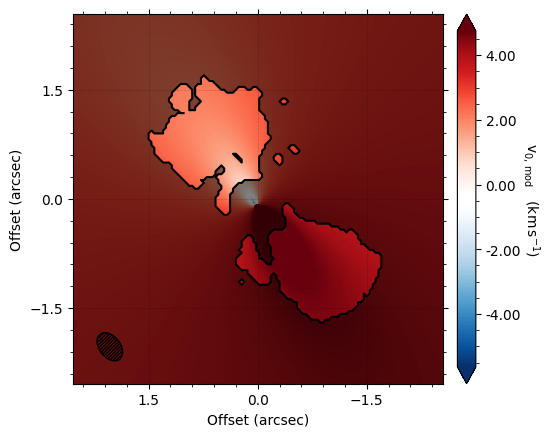

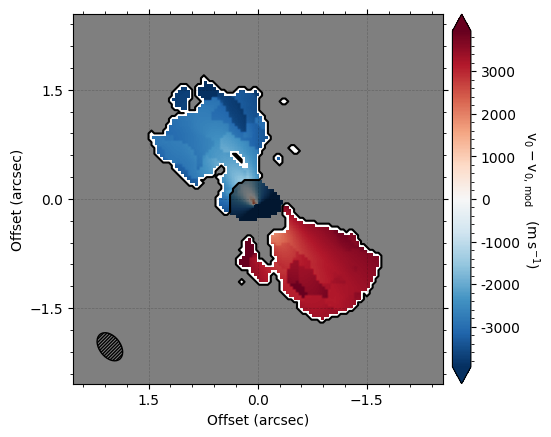

In [507]:
nwalkers, nburn, nsims = 10, 500, 100
if mask != None:
    ellipse_mask = create_ellipse_array(mask[0], mask[1], mask[4], [mask[2],mask[3]], infile, data_shape)
    masked_cube = mask_cube(ellipse_mask, infile, beam, v_scaling)
    samples, params, resid_fig = run_eddy_mcmc(masked_cube, offsets, (.4,2), 230, nwalkers, nburn, nsims)
else:
    samples, params, resid_fig = run_eddy_mcmc(cube, offsets, (.4,2), 230, nwalkers, nburn, nsims)


In [509]:
region = infile.split('/')[-2]
name = infile.split('/')[-1].split('_')[0]

lit_inc = disk_dict[region][name]['inclination']

if lit_inc != '--' and lit_inc != 0:
    eddy_vlsr = np.median([x[1] for x in samples])
    eddy_mstar = np.median([x[2] for x in samples])
    eddy_inc ='--'
else:
    eddy_vlsr = np.median([x[1] for x in samples])
    eddy_mstar = '--'
    eddy_inc = np.median([x[2] for x in samples])


disk_row = {
    'Name': name,
    'Region': region,
    'File': infile,
    'Emmision Line': infile.split('/')[-1].split('_')[1],
    'Channels': channels,
    'X-pos': disk_dict[region][name]['RA'],
    'Y-pos': disk_dict[region][name]['Dec'], 
    'X-offset': params['x0'],
    'Y-offset': params['y0'],
    'Literature PA': disk_dict[region][name]['PA'],
    'Eddy PA': np.median([x[0] for x in samples]),
    'Literature Mass [M]': disk_dict[region][name]['M_star'],
    'Eddy Mass [M]': eddy_mstar,
    'DECO Dict vsys [m/s]': disk_dict[region][name]['vsys'],
    'Eddy vlsr [m/s]': eddy_vlsr,
    'Literature Inc': disk_dict[region][name]['inclination'],
    'Eddy Inc': eddy_inc,
    'Literature Distance [Mpc]': disk_dict[region][name]['distance'],
    'Eddy rmin, rmax ["]': (params['r_min'],params['r_max']),
    'Eddy params (nwalkers, nburn, nsteps)': (nwalkers, nburn, nsims),
    'Velocity Mask': mask,
}

print(disk_row)

{'Name': 'J11075792-7738449', 'Region': 'ChamI', 'File': '/Users/calebpainter/Downloads/DustDrift2DiskMass/fits_files/ChamI/J11075792-7738449_CO_230.538GHz.image.fits', 'Emmision Line': 'CO', 'Channels': (0, 50, 150, 200), 'X-pos': 166.9906645833333, 'Y-pos': -77.64582250000001, 'X-offset': 0.020622417104469222, 'Y-offset': -0.09425664002264966, 'Literature PA': '--', 'Eddy PA': 213.07031304649018, 'Literature Mass [M]': 0.82, 'Eddy Mass [M]': '--', 'DECO Dict vsys [m/s]': 3.7, 'Eddy vlsr [m/s]': 3301.225516968699, 'Literature Inc': '--', 'Eddy Inc': 56.87965147003602, 'Literature Distance [Mpc]': 191.0, 'Eddy rmin, rmax ["]': (0.4, 2.0), 'Eddy params (nwalkers, nburn, nsteps)': (10, 500, 100), 'Velocity Mask': [2, 1.3, 0, 0, 45]}


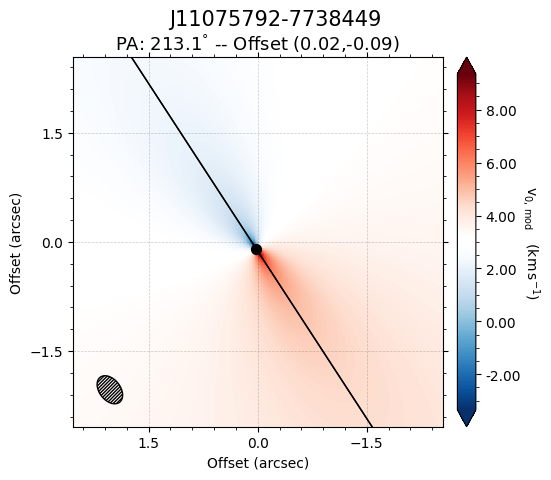

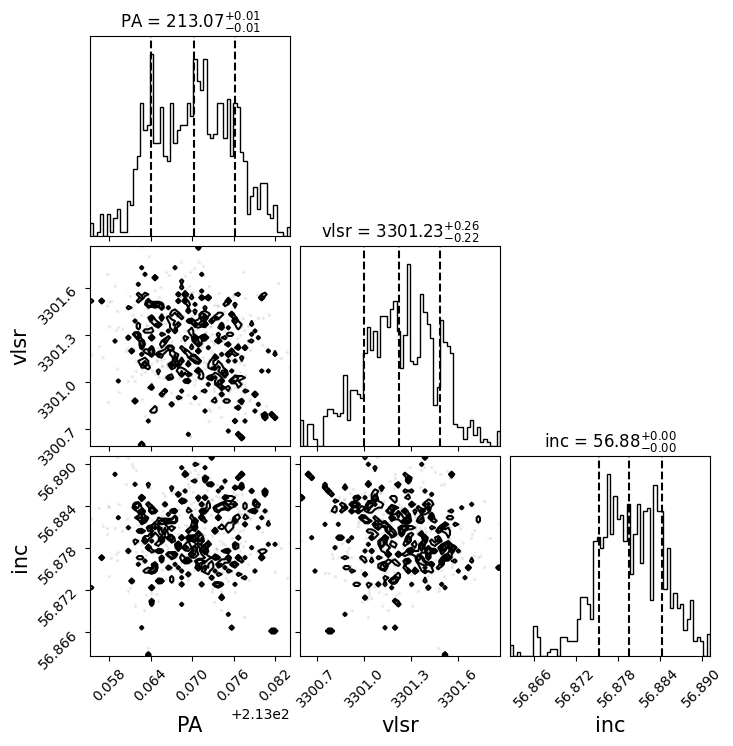

In [510]:
model_fig, resid_fig, rot_fig = plot_model_and_resids(samples, params, v_scaling, rot_fig, resid_fig, disk_row, postage_stamp_fig)

In [301]:
df = pd.read_csv('DECO_disk_eddy_outputs.csv', index_col=0)
df

,Name,Region,File,Emmision Line,Channels,X-pos,Y-pos,X-offset,Y-offset,Literature PA,Eddy PA,Literature Mass [M],Eddy Mass [M],DECO Dict vsys [m/s],Eddy vlsr [m/s],"Eddy rmin, rmax [""]",Literature Distance [Mpc],Literature Inc,Eddy Inc,"Eddy params (nwalkers, nburn, nsteps)"
0,J11080148-7742288,ChamI,/Users/calebpainter/Downloads/DustDrift2DiskMa...,CO,"(0, 115, 150, 200)",167.005759,-77.707936,-0.021829,0.279014,--,56.777366,0.705,9.984972,2.0,2260.868047,"(0.1, 1.5)",191.00,--,-5.675635193167284,NaN
1,J10590108-7722407,ChamI,/Users/calebpainter/Downloads/DustDrift2DiskMa...,CO,"(50, 92, 115, 150)",164.753828,-77.378032,-0.010764,-0.257546,-16.22,118.566141,0.700,1.042656,4.6,5128.965280,"(0.1, 1.5)",183.12,31.4,--,"(10, 200, 200)"


In [300]:
df = pd.concat([df, pd.DataFrame([disk_row])], ignore_index=True)
df.to_csv('DECO_disk_eddy_outputs.csv')

## Old messy code

In [341]:
name = infile.split('/')[-1].split('_')[0]
region = infile.split('/')[-2]
region = 'ChaI'

hdul = fits.open(infile)  # open aa FITS file
hdr = hdul[0].header  # the primary HDU header
dec = hdr['CRVAL2']
ra = hdr['CRVAL1'] 


center_ra = disk_dict['ChaI'][name]['RA']
center_dec = disk_dict['ChaI'][name]['Dec']

ra_diff_arcsecond = (center_ra - ra) * (np.cos(center_dec * np.pi / 180))*3600
dec_diff_arcsecond = (center_dec - dec) * 3600


KeyError: 'ChaI'

In [347]:
hdr['CDELT2'] * 3600

0.039999999999996004

NameError: name 'm1' is not defined

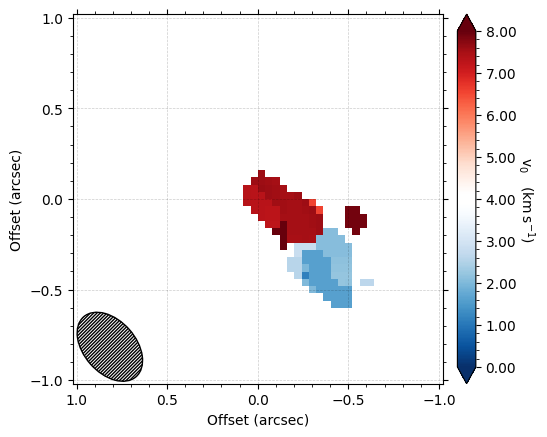

In [10]:
## do Eddy stuff
name = infile.split('/')[-1].split('_')[0]
cube = rotationmap(path=f'{infile[:-5]}_v0.fits',
                   uncertainty=f'{infile[:-5]}_dv0.fits',
                   FOV=2.0)
rot_fig = cube.plot_data(vmin=0, vmax=8, return_fig=True)
rot_axes_list = rot_fig.axes
rot_axes_list[0].set_title('Channels: '+f'{m1}-{m2},{m3}-{m4}')
rot_fig.suptitle(name)
rot_axes_list[0].scatter(ra_diff_arcsecond, dec_diff_arcsecond, color='black',s=20)

print(name)
# plt.savefig(f'/Users/calebpainter/Downloads/DustDrift2DiskMass/disk_plots_v/rotation_cube_map_{name}.png')

In [1116]:
# Dictionary to contain the disk parameters.

mass_prior =  center_ra = disk_dict['ChaI'][name]['M_star']
distance =  center_ra = disk_dict['ChaI'][name]['distance']

params = {}

# Start with the free variables in p0.
params['x0'] = ra_diff_arcsecond
params['y0'] = dec_diff_arcsecond
params['PA'] = 0
params['mstar'] = 1
params['vlsr'] = 2

# Provide starting guesses for these values.


# Fix the other parameters. All values which are to be fixed must be floats.

params['inc'] = 3 # degrees
params['dist'] = distance   # parsec

p0 = [320, mass_prior, 4e3, 20]



Assuming:
	p0 = [PA, mstar, vlsr, inc].
Starting positions:
	p0 = ['3.20e+02', '5.44e-01', '4.00e+03', '2.00e+01']


100%|██████████| 2000/2000 [01:26<00:00, 23.02it/s]


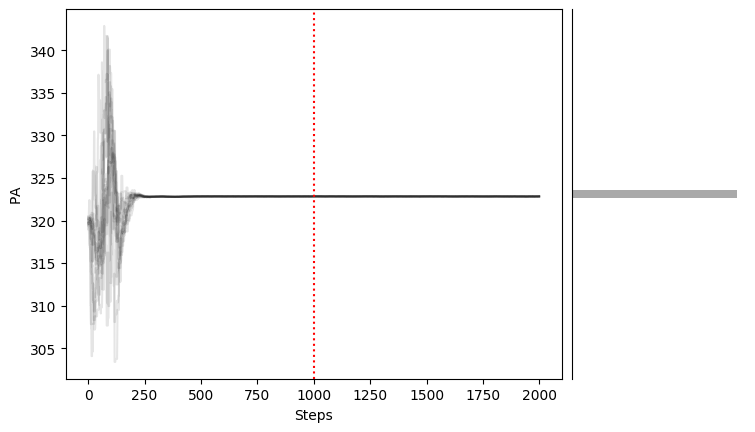

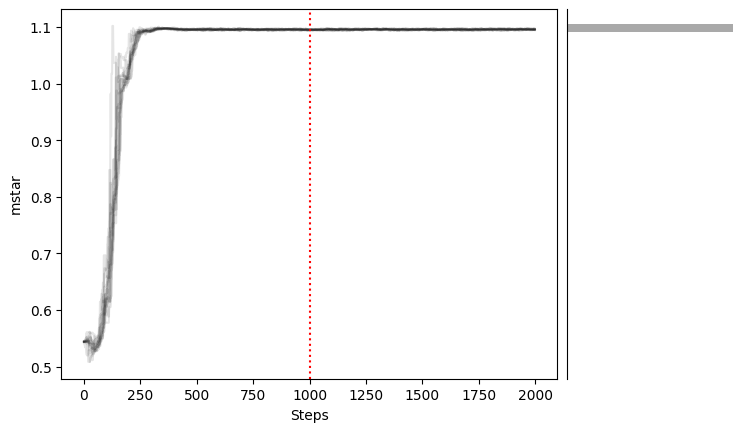

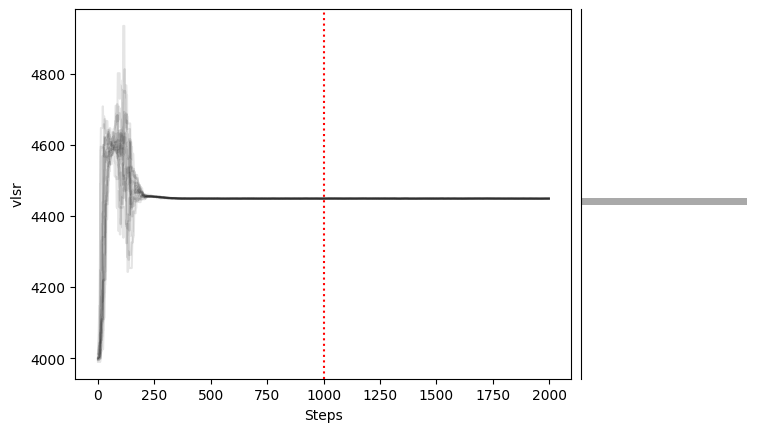

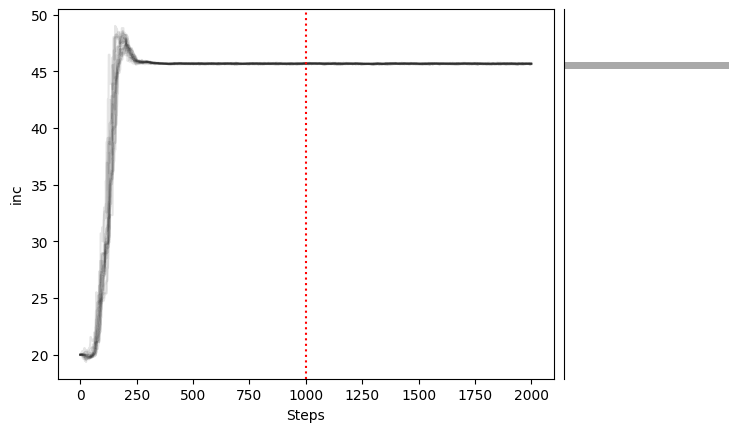

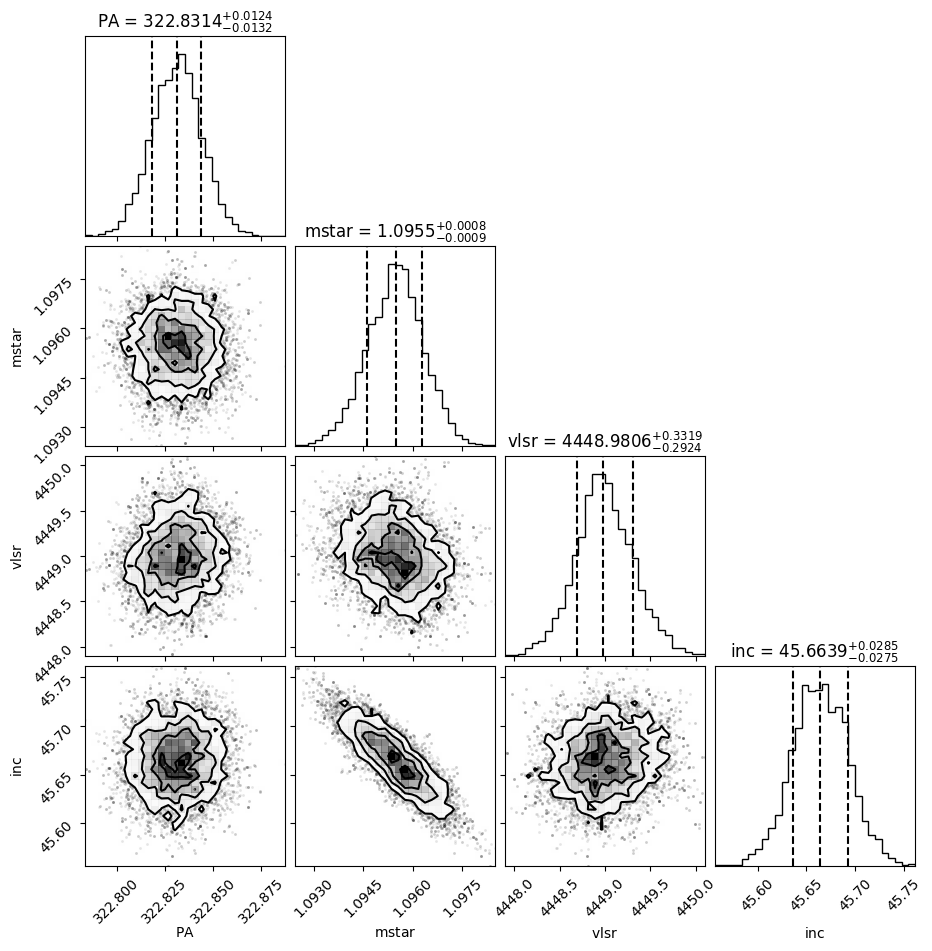

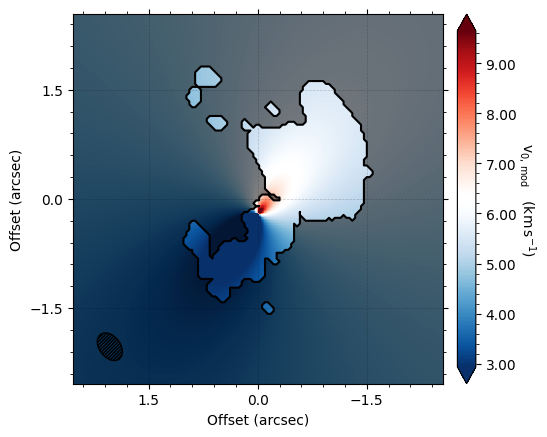

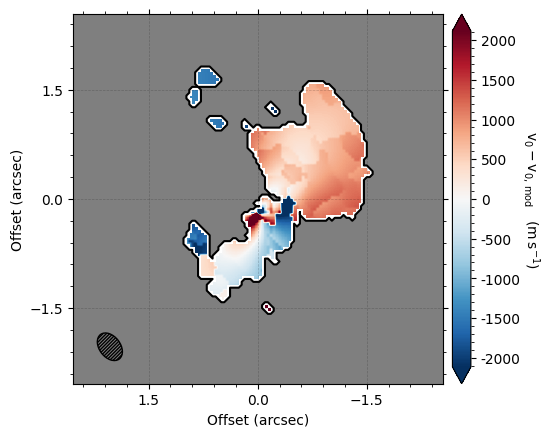

In [1092]:
nsims = 1000
nwalkers = 15

samples = cube.fit_map(p0=p0, params=params,
                       nwalkers=nwalkers, nburnin=1000, nsteps=nsims)

In [1094]:
# x_offset = np.median([x[0] for x in samples])
# y_offset = np.median([x[1] for x in samples])


PA = np.median([x[0] for x in samples])
M_star = np.median([x[1] for x in samples])
vlsr = np.median([x[2] for x in samples])

try:
    inc = np.median([x[3] for x in samples])
except:
    inc = params['inc']


PA_err_plus, PA_err_minus = np.percentile([x[0] for x in samples],84), np.percentile([x[0] for x in samples],16)

print(x_offset, ',', y_offset,',', PA, ',',(PA_err_plus-PA, PA-PA_err_minus),",",inc,',',(m1,m2,m3,m4))

322.83143469658614 , 1.0954854651279098 , 322.83143469658614 , (0.012393039886660517, 0.013244765532760994) , 45.66386960690285 , (0, 85, 120, 150)


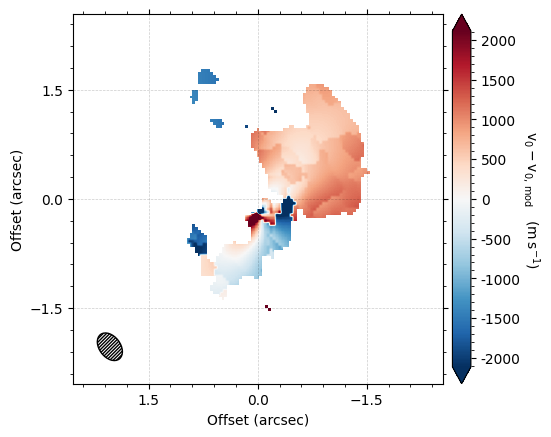

In [1095]:
model = cube.evaluate_models(samples=samples, params=params)

resid_fig = cube.plot_model_residual(model=model, return_fig=True, imshow_kwargs = {'vmin':})

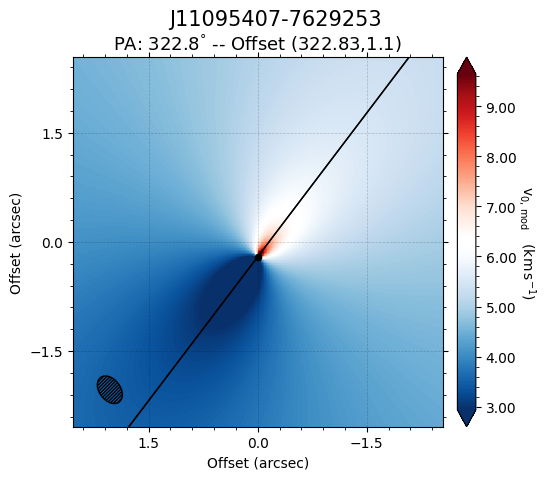

In [1096]:
model = cube.evaluate_models(samples=samples, params=params)
model_fig = cube.plot_model(model=model, return_fig = True,imshow_kwargs = {'vmin': 1.5})


axes_list = model_fig.axes

PA_slope = np.tan((PA+90)*np.pi / 180)
PA_slope_plus = np.tan((PA_err_plus+90)*np.pi / 180)
PA_slope_minus = np.tan((PA_err_minus+90)*np.pi / 180)


x= np.arange(-5,5,.1)
PA_line = -x * PA_slope
PA_line_plus = -x * PA_slope_plus
PA_line_min = -x * PA_slope_minus

axes_list[0].scatter(ra_diff_arcsecond, dec_diff_arcsecond, color='black',s=20)

axes_list[0].plot(x+ra_diff_arcsecond,PA_line_plus+dec_diff_arcsecond,color='black',linewidth=1)
axes_list[0].plot(x+ra_diff_arcsecond,PA_line_min+dec_diff_arcsecond,color='black',linewidth=1)


model_fig.suptitle(f"{infile.split('/')[-1].split('_')[0]}",fontsize=15)
axes_list[0].set_title(f"PA: {np.round(PA,1)}$^\degree$"+f" -- Offset ({np.round(x_offset,2)},{np.round(y_offset,2)})", fontsize=13,pad=5)
axes_list[0].scatter(x_offset,y_offset,s=50,color='black')
name = infile.split('/')[-1].split('_')[0]


# plt.savefig(f'/Users/calebpainter/Downloads/DustDrift2DiskMass/disk_plots_v/{name}.png')

In [1099]:
params.keys()

dict_keys(['x0', 'y0', 'PA', 'mstar', 'vlsr', 'inc', 'dist'])

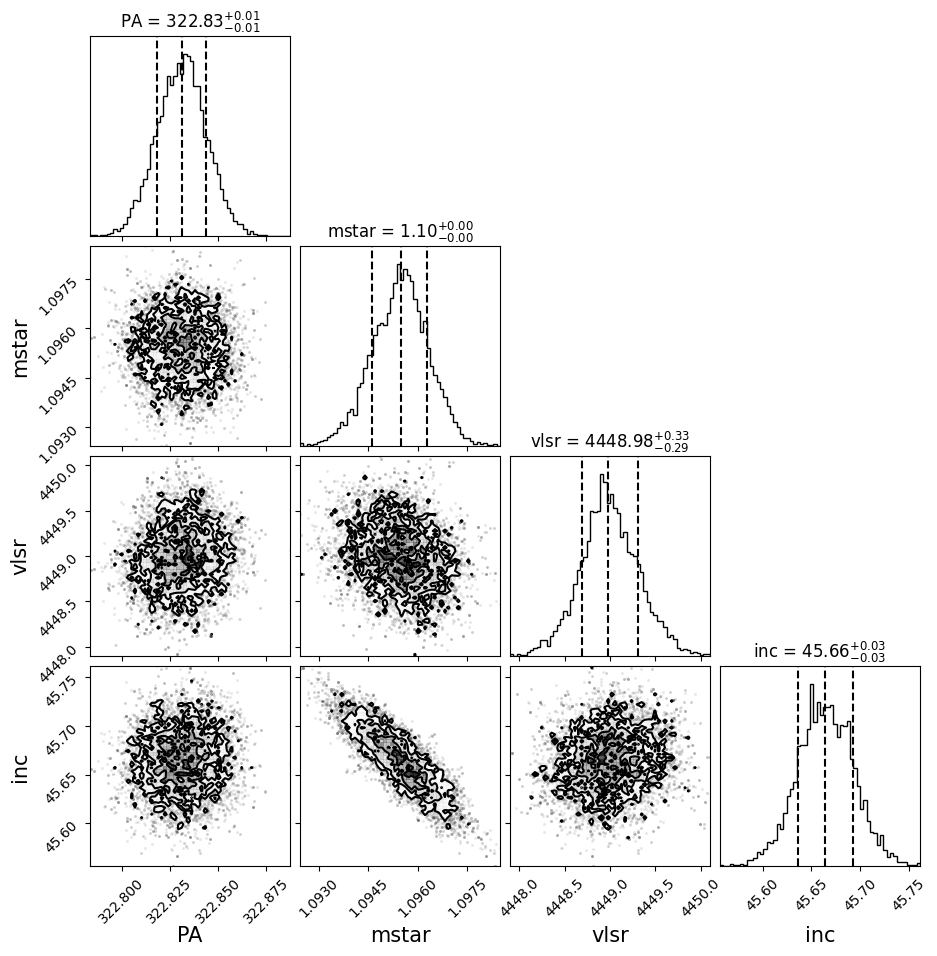

In [1101]:
corner_fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], labels=[l for l in list(params.keys())[2:6]], label_kwargs={"fontsize": 15}, show_titles=True, bins= 60)
rot_axes_list[0].plot(x+x_offset,PA_line_plus+y_offset,color='black',linewidth=1)
rot_axes_list[0].plot(x+x_offset,PA_line_min+y_offset,color='black',linewidth=1)


figs = [model_fig, rot_fig,resid_fig,corner_fig] # list of figures
with PdfPages(f'/Users/calebpainter/Downloads/DustDrift2DiskMass/disk_plots_v/full_diagnostic_{name}_{nsims}_sim_{nwalkers}_walkers.pdf') as pdf:
    for fig in figs:
        pdf.savefig(fig, bbox_inches='tight') 

## Continuum Inclination

In [965]:
import os

In [40]:
file_dir = '/Users/calebpainter/Downloads/products/new'
file_dirs = os.listdir(file_dir)
all_cont_files = []
for fdir in file_dirs:
    try:
        new_dir = file_dir+'/'+fdir+'/cont_images/'
        region_files = os.listdir(new_dir)
        all_cont_files.append(region_files)
    except:
        pass

In [46]:
CW

'J10590108-7722407'

In [60]:

file_dir = '/Users/calebpainter/Downloads/products/new'
file_dirs = os.listdir(file_dir)
all_cont_files = []
for fdir in file_dirs:
    try:
        new_dir = file_dir+'/'+fdir+'/cont_images/'
        region_files = os.listdir(new_dir)
        all_cont_files.append([new_dir + x for x in region_files])
    except:
        pass

disk_cont_file = None

for sublist in all_cont_files:
    for item in sublist:
        if name in item:
            disk_cont_file = item


In [61]:
all_cont_files

[['/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.CW_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.DL_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.DG_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3a.DS_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.GK_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.HO_Tau_sci.spw25_27_29_31_33_35_37_39_

/Users/calebpainter/Downloads/fits_downloads/J162713.7-241817_C18O_219.56GHz.image.fits


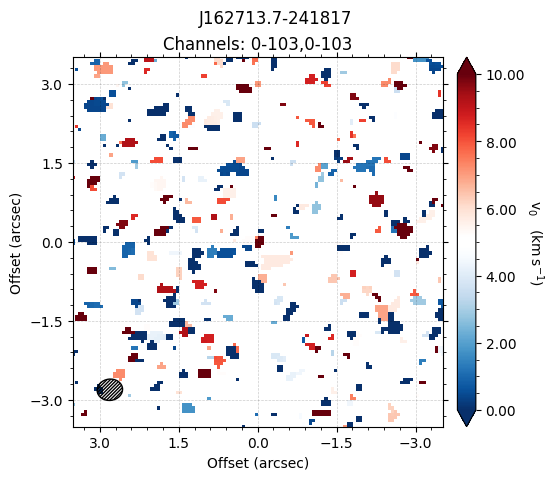

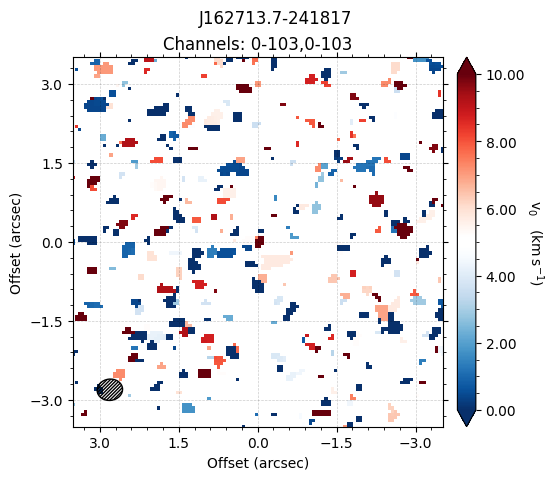

In [1012]:
file_number = 20
file_path = file_dir + file_paths[file_number]
print(file_path)

create_velocity_map(file_path,('full',0),3)


In [304]:
center_ra = disk_dict['ChamI'][name]['RA']
center_dec = disk_dict['ChamI'][name]['Dec']

# print(center_ra, center_dec)
print(Angle(center_ra * u.degree).hms,Angle(center_dec * u.degree).dms)

test_ra, test_dec = Angle('10:59:01.2301819678 hours').degree, Angle('-77:22:41.6674516505 degrees').degree
test_ra, test_dec

hms_tuple(h=10.0, m=59.0, s=0.9187000000009959) dms_tuple(d=-77.0, m=-22.0, s=-40.91459999996687)


(164.75512575819914, -77.37824095879179)